# Predicting number of days until a Department of Buildings Complaint is inspected

#### Authors:
- __Jeremy Ondov:__ [GitHub](https://github.com/ondovj)
- __Mahdi Shadkam-Farrokhi:__ [GitHub](https://github.com/Shaddyjr) 
---

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings(DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors.

We'll be using $R^2$ for model selection.

## Executive Summary
- Explaing we tried a bunch of possibilities for clustering and concluded using kmodes was best idea
- Tried GLM to no avail
- All non-time-series models performed very poorly

As part of our meta cleaning process we will drop any null observations.

We must account for this in our process as we're assuming these values are missing completely at random, or MCAR.

---
Running K-Modes and K-Prototypes with the same cluster number, but the additional feature of median income, does give different clusters/centroids. Given the significant increase in processing time between KModes and KPrototypes, it may be more efficient to only use KModes on the categorical features to cluster the datapoints, then integrate the income data as a feature in the final predictive model.

---

## Table of Contents
1. 
2. [Resources](#Resources)


## Data Dictionary
These data were cleaned from the original source using [the assocated cleaning notebook](./dob_data_cleaning.ipynb)

Column | Data Type | Description
- | - | :-
special_district|string|Indicates whether or not the building identified in the complaint is located in a Special District.
complaint_category|string|DOB Complaint Category Codes (01-Accident Construction/Plumbing, etc.)
unit|string|The most recent unit that was assigned to this complaint. It may have been initially assigned to one unit, and then referred to another unit for disposition.
zip_code|string|Zip code for the address of the building identified in the complaint.
med_inc_zip|integer|Median income imputed by zip code.
date_entered|date|Date complaint was filed
inspection_date|date|Date complaint was inspected
days_until_inspection|integer|Number of days between when complaint was filed and when it was officially inspected


## Loading libraries and data


In [78]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pickle

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

RANDOM_STATE = 12345

In [2]:
complaints = pd.read_csv('./datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered","inspection_date"])

In [3]:
complaints.head()

,special_district,complaint_category,unit,zip_code,med_inc_zip,date_entered,inspection_date,days_until_inspection
0,NOT SPECIAL,4B,SEP,10458,32129,2013-12-17,2013-12-24,7
1,NOT SPECIAL,73,MAN.,10075,129594,2009-09-21,2009-10-03,12
2,NOT SPECIAL,37,ERT,10011,123208,2015-09-02,2015-09-03,1
3,NOT SPECIAL,23,ERT,10462,49962,2010-08-25,2010-10-09,45
4,NOT SPECIAL,90,CITY,11220,42559,2009-07-20,2009-09-15,57


## Data Cleaning
Most of the major cleaning was done during the previous cleaning steps. Some ancillary data cleaning is still needed, however.

### Removing Outliers

The dataset has some significant outliers, which bear consideration; we've decided to remove these extreme observations from our training set.

In [4]:
complaints["days_until_inspection"].describe()

count    81739.000000
mean        87.204419
std        204.906661
min          1.000000
25%          5.000000
50%         24.000000
75%         84.000000
max       3402.000000
Name: days_until_inspection, dtype: float64

In [5]:
complaints["days_until_inspection"].max() / 365 # converting days to years

9.32054794520548

We can see some extreme DOB complaints took over 9 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this. Perhaps there's a pattern or some other commonality between these extreme observations.

---
#### An odd date

During model evaluation, we found the date associated with 2009-04-02 to have usual observations with large `days_until_inspection`

In [6]:
odd_dates = ["2009-04-02"]
complaints[complaints["date_entered"].isin(odd_dates)].sort_values("inspection_date", ascending = False).head()

,special_district,complaint_category,unit,zip_code,med_inc_zip,date_entered,inspection_date,days_until_inspection
60022,NOT SPECIAL,1G,EXCAV,11224,31630,2009-04-02,2018-06-29,3375
7046,NOT SPECIAL,1G,EXCAV,11211,66113,2009-04-02,2016-12-30,2829
50503,NOT SPECIAL,1G,EXCAV,10035,27932,2009-04-02,2014-08-25,1971
2149,NOT SPECIAL,1G,EXCAV,10035,27932,2009-04-02,2014-08-25,1971
88329,NOT SPECIAL,1G,EXCAV,10027,45536,2009-04-02,2014-07-28,1943


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

---

To improve model performance, we'll remove all observations with more than 2800 days until inspection, or a little under 8 years.

In [7]:
# Setting outlier threshold
outlier_threshold = 2800
extreme_obs = complaints[complaints["days_until_inspection"] >= outlier_threshold].sort_values("days_until_inspection", ascending = False)
extreme_obs["unit"].value_counts()

QNS.     12
BRONX     6
EXCAV     6
ERT       4
MAN.      3
SCFLD     3
BKLYN     3
STALL     1
CITY      1
BEST      1
Name: unit, dtype: int64

There may be some association with these exceptionally long inspection times and the `unit` "QNS.".

In [8]:
extreme_obs.shape

(40, 8)

In [9]:
# percentage of all data
round(extreme_obs.shape[0] / complaints.shape[0], 4) * 100

0.05

We find 40 outlier observations, which account for about .05% of the data.`

In [10]:
# removing outliers
complaints.drop(index = extreme_obs.index, inplace = True)

## Exploratory Data Analysis

### Defining helper functions

In [11]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    
    return " ".join([word.capitalize() for word in string.replace("_"," ").split()])

In [12]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height< 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel,ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index)

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index)    
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

In [13]:
def graph_time_aggregation(dataset, x, y, time_span, title):
    '''Plots a basic line plot based on a time_span aggregated by summation'''
    plt.title(title)
    dataset_by_time_span = dataset.resample(time_span).sum()
    sns.lineplot(y = dataset_by_time_span[y], x = dataset_by_time_span.index);
    plt.ylabel(capitalize_words(y))
    plt.xlabel(capitalize_words(x))

### Exploring Days Until Inspection

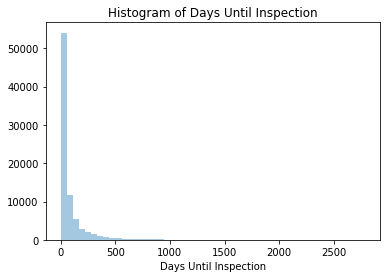

In [14]:
# Original `days_until_inspection`
plt.title("Histogram of Days Until Inspection")
sns.distplot(complaints["days_until_inspection"], kde = False, bins = 50, axlabel = "Days Until Inspection");

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or __gamma distribution.__ This makes even more sense, considering our target is a continuous non-negative value detailing a "time until an event occurs". 

#### Log transformation
Skewed distributions can sometimes be coerced to look more normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

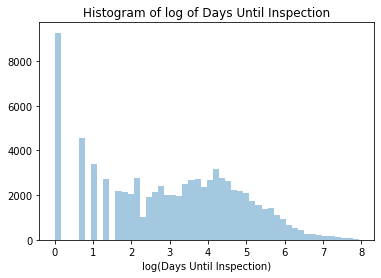

In [15]:
# Log transformed `days_until_inspection`
plt.title("Histogram of log of Days Until Inspection")
sns.distplot(np.log(complaints["days_until_inspection"]), axlabel="log(Days Until Inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

Given the temporal nature of our target, we suspect there are time-related dependencies.

In [16]:
# preparing data for visualization 
complaints_with_time_index = complaints.set_index("date_entered")[["days_until_inspection"]]

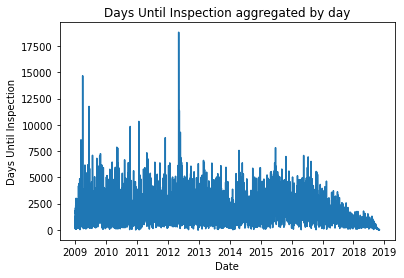

In [17]:
# by day
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "D", 
    "Days Until Inspection aggregated by day"
)

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

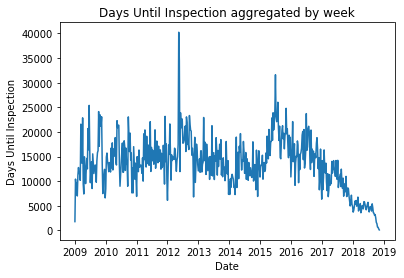

In [18]:
# by week
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "W", 
    "Days Until Inspection aggregated by week"
)

It's difficult to tell if there's any seasonality in these data when aggregating by week.

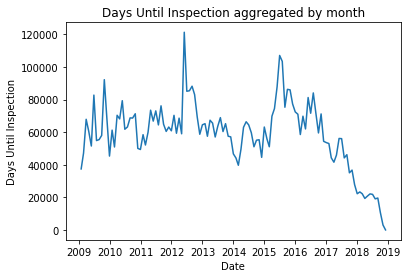

In [19]:
# by month
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "M", 
    "Days Until Inspection aggregated by month"
)

There may be some seasonality by month, though it appears somewhat irregular.

---
__We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.__

#### Testing for seasonality
For simplicity, we'll test for seasonality using with average days until inspection _by month._

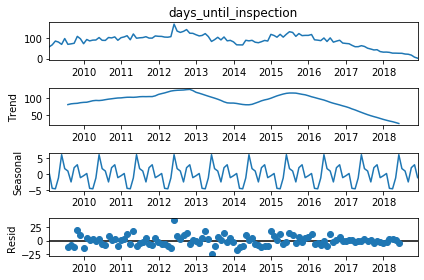

In [20]:
# aggregating mean days_until_inspection by month
avg_days_until_inspection_by_month = complaints_with_time_index.resample("M").mean()
seasonal_decompose(avg_days_until_inspection_by_month["days_until_inspection"]).plot()
plt.show()

After decomposing the data __we find a seasonal component, which suggests a SARIMAX model may be worth exploring.__

### Exploring Special District

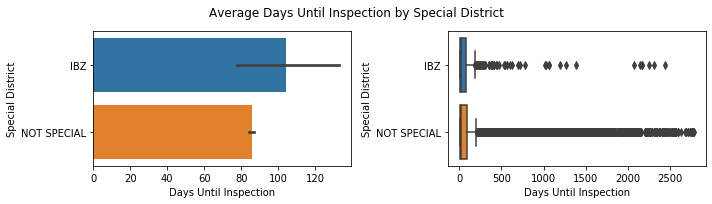

In [21]:
# Special District
aggregation_plots(complaints, "days_until_inspection", "special_district")

__We do not see a significant difference in average `days_until_inspection` between Special Districts,__ however we do see a wide range in individual observations for "NOT SPECIAL" districts.

### Exploring Unit

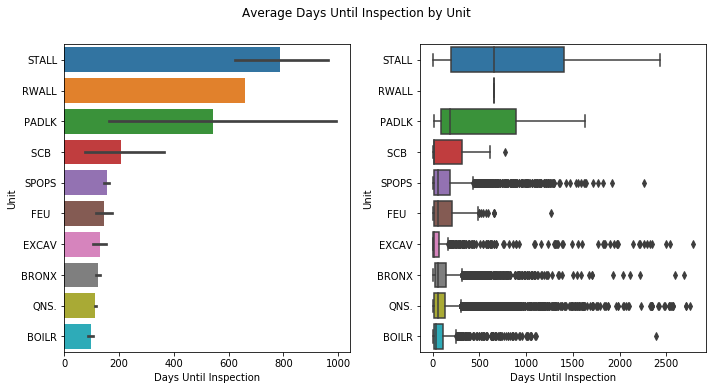

In [22]:
# Unit
aggregation_plots(complaints, "days_until_inspection", "unit")

__The STALL and PADLK units appear to have the longest average days until inspection__ with little different between the other units. Other Units, however, have much more extreme outliers.

### Exploring Complaint Category

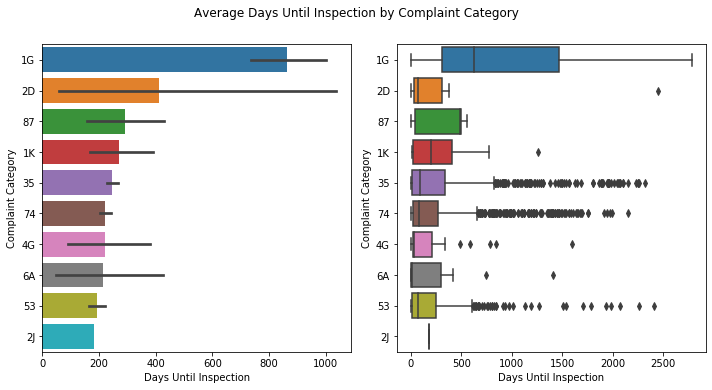

In [23]:
# Complaint Category
aggregation_plots(complaints, "days_until_inspection", "complaint_category")

__The "1G" complaint category appears to take significantly longer to inspect than all other categories,__ even when taking into account the extreme ranges seen in those categories. 

We may want to consider splitting our dataset to handle "1G" and non-"1G" complaint categories.

### Exploring Zip Code

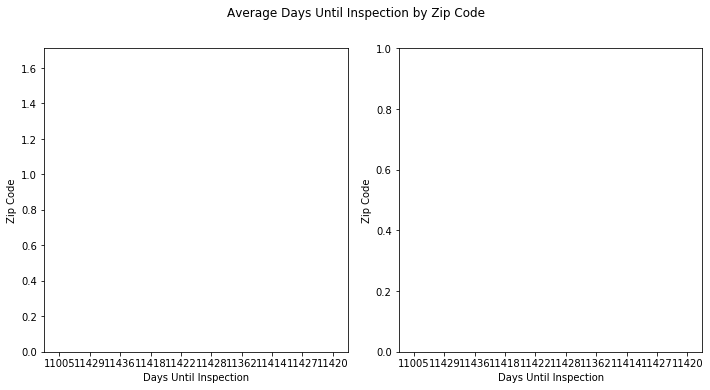

In [24]:
# Zip Code
aggregation_plots(complaints, "days_until_inspection", "zip_code")

Zip Code does not appear to be a significant feature.

In addition, we encountered a number of issues with these data zip codes:
- Many zip codes were missing and while we were able to infer the zip codes, based in the `house_street` and `house_number` and using the Google Maps API, this proved to be impractical.
- A few zip codes also appeared to be outdated. Over time the city of New York has decommissioned some zip codes and created new ones (for example, 11249). Such zip codes were in the dataset, and would require further assumptions to be made.

For these reasons __we'll be removing the Zip Code feature from model consideration.__

### Exploring Median Income

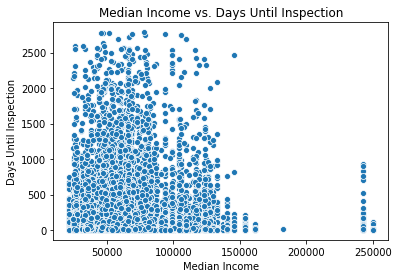

In [25]:
# Median Income
plt.title("Median Income vs. Days Until Inspection")
sns.scatterplot(data = complaints, x = "med_inc_zip", y = "days_until_inspection");
plt.xlabel("Median Income")
plt.ylabel("Days Until Inspection");

Besides a few extreme income values, __there does not appear to be a clear correlation between median income and the number of days until a complaint is inspected.__

### Feature Engineering - K-Modes Clustering

In order to find further connections between the complaint entries that may help the modeling phase, we are going to apply clustering as a form of EDA and feature engineering. As most of the data here is categorical, we are going to use the KModes modeling technique, which is an adaptation of KMeans clustering. As categorical data cannot truly have distances between values, KMeans is not an accurate tool for this scenario. Instead of numerical distances, KModes utilizes each row's combined values of each category (column, or feature), and determines for each cluster what the mode of that category  is. For each row, the number of columns where these values differs becomes the "distance". In this way, the algorithm can still determine the similarity and difference between the entries and the cluster "centroids".

For this process, we are only interested in the categorical columns that are going to have an impact on the modeling phase. Complaint status, address, and others are not needed for this analysis so they can be dropped. The included zip code median income will also be dropped as it is a continuous numerical feature and will not be available for the KModes algorithm.

#### Preprocessing

We'll select the key features we plan to put into the model and use K-prototypes to create a column of possible clusters as a way of improving model performance.

In [26]:
# selected features
kmode_features = ["special_district", "complaint_category", "unit"]

kmode_df = complaints[kmode_features]
kmode_df.head()

,special_district,complaint_category,unit
0,NOT SPECIAL,4B,SEP
1,NOT SPECIAL,73,MAN.
2,NOT SPECIAL,37,ERT
3,NOT SPECIAL,23,ERT
4,NOT SPECIAL,90,CITY


One of the difficult parts of clustering analysis is to determine the optimal number of clusters to choose (when using algorithms that cannot determine this on their own). To aid in this determination, we will loop through a range of cluster numbers, and analyze each model's cost, defined in the library documentation as the sum distance of all points to their respective cluster centroids, to determine the optimal number of clusters.

We will create a dictionary to store each of the model instances, with the number of clusters being used at the key for each model. We will also separately store the costs for each model to easily access these values. The targeted range of cluster numbers will be all numbers from 3 to 20.

#### Searching for best `n_clusters`

In [27]:
# setting dictionary and lists to store models/results
km_objs = []
# looping through cluster range
for i in range(3, 10, 1):
    print("running KModes with ", i, "clusters")
    km = KModes(n_clusters = i, n_init = 10, random_state = RANDOM_STATE, n_jobs = -1, verbose = 2)
    km_objs.append(km.fit(kmode_df))

running KModes with  3 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  4 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  5 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  6 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  7 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  8 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  9 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  10 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  11 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  12 cl

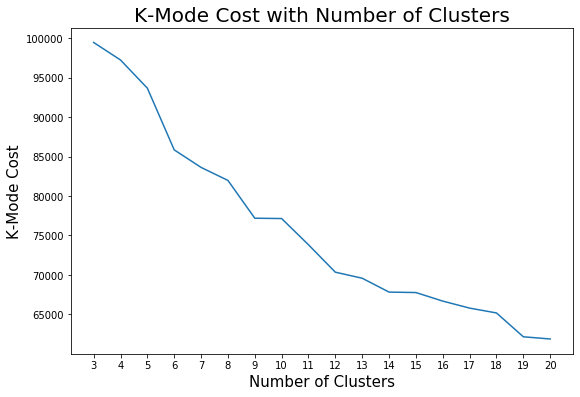

In [28]:
plt.figure(figsize=(9, 6))
plt.plot(range(3, len(km_objs) + 3), [km_obj.cost_ for km_obj in km_objs])
plt.title("K-Mode Cost with Number of Clusters", size=20)
plt.xticks(range(3, len(km_objs) + 3))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("K-Mode Cost", size=15);

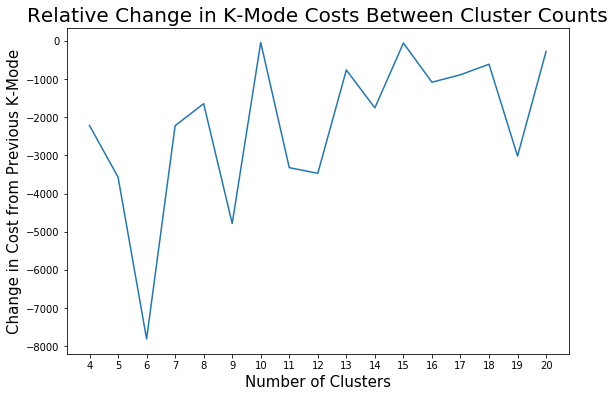

In [29]:
plt.figure(figsize=(9, 6))
plt.plot(range(4, len(km_objs) + 3), [obj.cost_ - km_objs[i].cost_ for i, obj in enumerate(km_objs[1:])])
plt.title("Relative Change in K-Mode Costs Between Cluster Counts", size=20)
plt.xticks(range(4, len(km_objs) + 3))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Change in Cost from Previous K-Mode", size=15);

#### Exploring best `n_clusters`

In [30]:
# exploring n_clusters = 6
km_objs[3].cluster_centroids_

array([['NOT SPECIAL', '45', 'QNS.'],
       ['NOT SPECIAL', '05', 'BKLYN'],
       ['NOT SPECIAL', '63', 'ERT  '],
       ['NOT SPECIAL', '83', 'ELEVR'],
       ['NOT SPECIAL', '73', 'MAN.'],
       ['NOT SPECIAL', '4B', 'SEP  ']], dtype='<U11')

In [31]:
pd.Series(km_objs[3].labels_).value_counts(normalize = True)

0    0.520863
1    0.186918
2    0.179292
5    0.047797
4    0.037981
3    0.027148
dtype: float64

I appears over half of the observations belong to the first cluster, which tend to belong to the complaint category "45" and are handled by the "QNS." unit.

#### Adding cluster column

In [32]:
# adding clusters to dataset
complaints["cluster"] = (km_objs[3].labels_ + 1).astype(str) # must be categorical

### Exploring clusters

#### Average Median Income by Cluster

In [33]:
med_by_cluster = complaints.groupby("cluster")["med_inc_zip"].mean().sort_values()
med_by_cluster

cluster
3    60486.188900
1    63541.510880
2    64142.703490
4    65544.562218
6    66493.746735
5    85021.932001
Name: med_inc_zip, dtype: float64

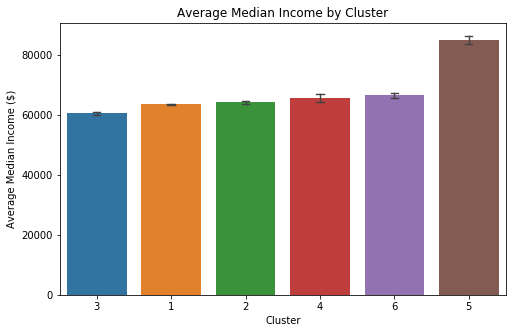

In [34]:
plt.figure(figsize=(8,5))
plt.title("Average Median Income by Cluster")
sns.barplot(data = complaints, x = "cluster", y = "med_inc_zip", capsize = .1, errwidth = 1.4, order = med_by_cluster.index)
plt.ylabel("Average Median Income ($)")
plt.xlabel("Cluster");

Many clusters do not seem to show a large distinction between each other, however, the 5th cluster appears to have a significantly higher average median income. This may show a connection between the other features and median income.

#### Days until inspection by cluster

In [35]:
days_by_cluster = complaints.groupby("cluster")["days_until_inspection"].mean().sort_values()
days_by_cluster

cluster
6    44.754417
4    45.641118
3    72.862234
2    91.008840
1    93.459581
5    95.059297
Name: days_until_inspection, dtype: float64

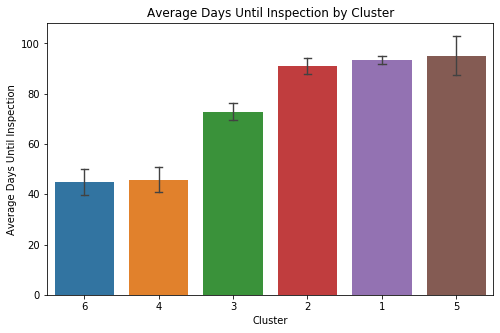

In [36]:
plt.figure(figsize=(8,5))
plt.title("Average Days Until Inspection by Cluster")
sns.barplot(data = complaints, x = "cluster", y = "days_until_inspection", capsize = .1, errwidth = 1.4, order = days_by_cluster.index)
plt.ylabel("Average Days Until Inspection")
plt.xlabel("Cluster");

Again, we some some clusters have a very similar average days until being inspected, but do some roughly 3 unique groups of clusters that may serve as a useful feature for modeling.

## Model Preperation

In [37]:
target = "days_until_inspection"
features = ["special_district", "complaint_category", "unit", "med_inc_zip", "cluster"]

# establish features
X = pd.get_dummies(complaints[features], drop_first = True)
# establish target
y = complaints[target]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

## Modeling

First, we'll explore some traditional models, such as Random Forest and Gradient Boost.

Then, we'll see if an ARIMA or SARIMAX model perform better with our time-sensative target variable.

### Baseline Model

In [50]:
dummy = DummyRegressor("mean")

dummy.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [51]:
# train score
dummy.score(X_train, y_train)

0.0

In [52]:
# test score
dummy.score(X_test, y_test)

-6.908867839650057e-05

In [53]:
# train score
cross_val_score(dummy, X, y).mean()

-2.6506864257846984e-05

As expected, the baseline model performs close to 0 $R^2$. Any model that can perform better will be better than blindly guessing the average number of days until a complaint is inspected.

### Random Forest

In [38]:
rf = RandomForestRegressor()

rf_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

rf_gs = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1)

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [39]:
rf_gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [40]:
# train score
rf_gs.score(X_train, y_train)

0.3558951095336669

In [41]:
# test score
rf_gs.score(X_test, y_test)

0.07684546815100224

In [42]:
# train score
cross_val_score(rf_gs.best_estimator_, X, y).mean()

0.06794911854705883

Given how underfit our model is with a training $R^2$ of 35% and a testing $R^2$ of 8%, a natural next step would be to try a boosting model.

### Gradient Boost

In [43]:
gb = GradientBoostingRegressor()

gb_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

gb_gs = GridSearchCV(gb, gb_params, cv = 5, n_jobs = -1)

gb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [45]:
gb_gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [46]:
# train score
gb_gs.score(X_train, y_train)

0.3818546286259279

In [47]:
# test score
gb_gs.score(X_test, y_test)

-0.0015151720420079064

In [48]:
# train score
cross_val_score(gb_gs.best_estimator_, X, y).mean()

0.009306655058501612

Yet again, our model is underfit. With a training $R^2$ of 38% and a testing $R^2$ close to 0%, the Gradient Boost model does no better than our baseline model.

---
Given the temporal nature of our target and the clear lack of correlation between our features and our target, we'll explor an ARIMA model using only the target.

## ARIMA
We've already seen some seasonality components in our data, which is a motivating reason for exploring a ARIMA model.

In [63]:
# ARIMA SETUP
arima_df = complaints.set_index("date_entered")[["days_until_inspection"]].resample("M").mean().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

We can use the Augmented Dickey Fuller hypothesis test to check for stationarity - a requirement for ARIMA.

In [64]:
# no differencing
result = adfuller(arima_df[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.171795
p-value: 0.970635
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


In [65]:
# diff of 1
arima_df_diff_1 = arima_df[target].diff(1).dropna()
result = adfuller(arima_df_diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.073405
p-value: 0.000000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


By __differencing once,__ with a 95% confidence, we reject the null hypothesis accept our data has stationarity (`d = 1`).

#### Determining `p` using autocorrelation function

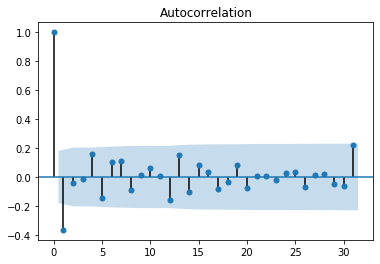

In [66]:
plot_acf(arima_df_diff_1, lags=31)
plt.show()

Using the once differenced data, we find a strong negative correlation between months within 1 lag and no other significant lags. This suggests we have to consider a moving average and assume no auto-regression (`p = 0`).

#### Determining `q` using partial-autocorrelation function

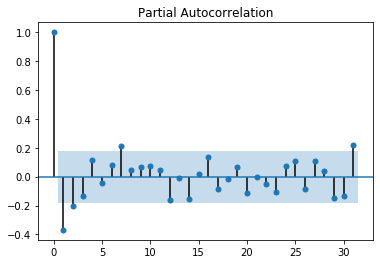

In [58]:
plot_pacf(arima_df_diff_1, lags=31)
plt.show()

We see an immediate significant lag that trails off to insignificance. We will use the first lag from the autocorrelation to determine the moving average term (`q = 1`).

### Hyperparameter searching using `auto_arima`

To verify our findings for the order as $(p,q,d) = (0,1,1)$, we can use `auto_arima` to gridsearch the best order for our ARIMA model.

In [67]:
fitted_arima = auto_arima(
    arima_df,
    d = 1,
    start_p = 0, start_q = 0,
    seasonal = False
)

In [68]:
fitted_arima.order

(0, 1, 1)

We're confident an order of (0,1,1) is best to use in our model.

### Model Preparation for ARIMA

In [80]:
order = (0, 1, 1)
X, y = train_test_split(arima_df, test_size = .1, shuffle = False)

#### Time Series Baseline Model

In [98]:
dummy_arima = DummyRegressor("mean")

dummy_arima.fit(X, X)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [99]:
# train score
dummy_arima.score(X, X)

0.0

In [100]:
# test score
dummy_arima.score(y, y)

-63.186773880815835

### Fitting and Scoring ARIMA

In [84]:
arima = ARIMA(X, order = order)

fitted_arima = arima.fit()

In [91]:
fitted_arima.predict(start=len(X),end= len(X) + len(y) - 1, dynamic = True)

2017-12-31    4.453162
2018-01-31   -0.253411
2018-02-28   -0.253411
2018-03-31   -0.253411
2018-04-30   -0.253411
2018-05-31   -0.253411
2018-06-30   -0.253411
2018-07-31   -0.253411
2018-08-31   -0.253411
2018-09-30   -0.253411
2018-10-31   -0.253411
2018-11-30   -0.253411
Freq: M, dtype: float64

## SARIMAX


#### Determining `S`, seasonal component

In [ ]:
seasonal_decompose(arima_df_diff_1).plot()
plt.show()

We find a strong weekly seasonal component, however the 

### Modeling SARIMA

In [ ]:
sarima = SARIMAX(endog = arima_db.values,
                 order = (p, d, q),
                 seasonal_order = (P, D, Q, S),
                 exog = exog.values
                )

fitted_sarima = sarima.fit()

In [ ]:
vizResids("SARIMA Results", "Days Until Inspection", arima_db[target], fitted_sarima.predict(start=0,end=-1))

### Modeling SARIMAX

In [ ]:
sarimax = SARIMAX(endog = arima_db.values,
                 order = (p, d, q),
                 seasonal_order = (P, D, Q, S),
                 exog = exog.values
                )

fitted_sarimax = sarimax.fit()

In [ ]:
vizResids("SARIMAX Results", "Days Until Inspection", arima_db[target], fitted_sarimax.predict(start=0,end=-1))

## Classification Model
By converting target into classes, can simplify model and increase performance

## Model Selection

## Model Evaluation

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [ ]:
def vizResids(model_title, target_name,y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(12,10)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ ={score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .5)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = y_preds, y = resids, alpha = .5)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

## Conclusion

## Recommendations

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)